In [1]:
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ALLCools.plot.color import *
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Cell Meta

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

In [4]:
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = {k.replace(' ', '_'): v for k, v in sub_type_palette.items()}

def hex_to_rgb(c):
    return tuple(int(c[1:][i:i+2], 16) for i in (0, 2, 4))

sub_type_palette_rgb = {k: hex_to_rgb(v) for k, v in sub_type_palette.items()}

### Dendrogram

In [5]:
exc_dendro = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/ExcGeneToTree/Dendrogram.lib'
)
inh_dendro = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/InhGeneToTree/Dendrogram.lib'
)
use_clusters = exc_dendro['ivl'] + inh_dendro['ivl']
use_clusters = [i.replace(' ', '_') for i in use_clusters]

## ATAC peaks

In [6]:
atac_peak = pd.read_msgpack('SubType.ATAC_peak_merged.msg')

## Gene Info

In [7]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')

In [8]:
exon_bed = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/genome_anno/exon.all.bed',
    header=None,
    sep='\t')
exon_bed.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name']

In [9]:
def get_gene(gene_name):
    _gene = gene_meta[gene_meta['gene_name'] == gene_name]
    return _gene.index[0], _gene.iloc[0, 0], _gene.iloc[0, 3], _gene.iloc[
        0, 4], _gene.iloc[0, 6]

## DMR Info

In [10]:
with pd.HDFStore(
        '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5',
        'r') as hdf:
    dmr_rate = hdf['Rate']

dmr_corr = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/TotalGeneDMRCorrLoop.0.3.msg')
dmr_corr = dmr_corr.set_index(['DMR', 'Gene'])

dmr_bed = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/TotalDMR.nofilter.bed',
    sep='\t',
    header=None,
    index_col=3)
dmr_bed.columns = ['chrom', 'start', 'end']

dmr_hits = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/TotalHits.HypoDMR.h5ad'
)
dmr_hits = dmr_hits[:, use_clusters].copy()

dmr_annot = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRAnnotation.h5ad'
)

In [11]:
dmr_hits.shape[0]

4722053

## Gene's DMR clustering

In [12]:
gene_name = 'Adarb2'
slop = 250000
n_pc = 6
resolution = 1.5

In [13]:
import pathlib

gene_dir = pathlib.Path(gene_name)
gene_dir.mkdir(exist_ok=True)

In [14]:
def calculate_gene(gene_name):
    # get gene information
    gene_id, gene_chrom, gene_start, gene_end, _ = get_gene(gene_name)

    # select related DMRs
    related_dmr = dmr_bed[(dmr_bed['chrom'] == gene_chrom)
                          & (dmr_bed['start'] > gene_start - slop) &
                          (dmr_bed['end'] < gene_end + slop)].copy()

    related_dmr_rate = dmr_rate.loc[related_dmr.index, use_clusters].copy()
    related_dmr_rate.fillna(related_dmr_rate.mean(), axis=0, inplace=True)

    # construct Adata
    adata = anndata.AnnData(X=related_dmr_rate.values.copy(),
                            obs=pd.DataFrame([], related_dmr_rate.index),
                            var=pd.DataFrame([], related_dmr_rate.columns))
    sc.pp.scale(adata)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata)

    pcs = adata.obsm['X_pca'][:, :n_pc]
    sc.pp.neighbors(adata,
                    n_neighbors=int(round(np.log2(adata.shape[0]))),
                    n_pcs=n_pc)
    sc.tl.leiden(adata, resolution=resolution)
    return adata.obs

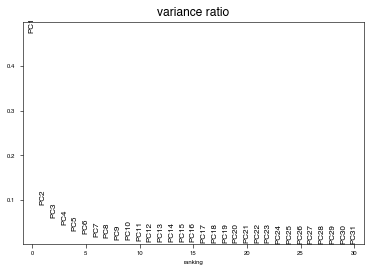

0     202
1     155
2     152
3     125
4     119
5     117
6     116
7     116
8     110
9     106
10     92
11     87
12     86
13     75
14     72
15     71
16     62
17     53
18     36
19     14
20     10
Name: leiden, dtype: int64

In [15]:
gene_id, _, gene_start, gene_end, strand = get_gene(gene_name)
tss = gene_start if strand == '+' else gene_end
gene_length = gene_end - gene_start

gene_cluster = calculate_gene(gene_name)
gene_cluster['leiden'].value_counts()

## Annotate DMRs

In [16]:
# add corr info
this_corr = dmr_corr[dmr_corr.index.get_level_values('Gene') ==
                     gene_id]['Corr']
this_corr.index = this_corr.index.droplevel('Gene')
gene_cluster['Corr'] = gene_cluster.index.map(this_corr).fillna(0)

# add genebody location info
this_dmr_bed = dmr_bed.loc[gene_cluster.index]
dmr_center = (this_dmr_bed['end'] + this_dmr_bed['start']) / 2
if strand == '+':
    gene_cluster['reldist_tss'] = (dmr_center - gene_start) / gene_length
else:
    gene_cluster['reldist_tss'] = (gene_end - dmr_center) / gene_length
gene_cluster['in_gene_body'] = (gene_cluster['reldist_tss'] > 0) & (gene_cluster['reldist_tss'] < 1)

# add annotation infos
this_annot = dmr_annot[gene_cluster.index]
annot_df = pd.DataFrame(this_annot.X.todense(),
                        index=this_annot.obs_names,
                        columns=this_annot.var_names)
# annotate TE cols
dna_te = annot_df.columns[20:33]
gene_cluster['is_dna_te'] = annot_df[dna_te].sum(axis=1) != 0

line_te = annot_df.columns[33:39]
gene_cluster['is_line_te'] = annot_df[line_te].sum(axis=1) != 0

ltr_te = annot_df.columns[39:45]
gene_cluster['is_ltr_te'] = annot_df[ltr_te].sum(axis=1) != 0

sine_te = annot_df.columns[45:52]
gene_cluster['is_sine_te'] = annot_df[sine_te].sum(axis=1) != 0
# this dmr within GOI's gene feature
gene_cluster['in_intron'] = annot_df['intron'].astype(
    bool) & gene_cluster['in_gene_body']
gene_cluster['in_exon'] = annot_df['exon'].astype(
    bool) & gene_cluster['in_gene_body']
gene_cluster['in_utr3'] = annot_df['UTR3'].astype(
    bool) & gene_cluster['in_gene_body']
gene_cluster['in_utr5'] = annot_df['UTR5'].astype(
    bool) & gene_cluster['in_gene_body']
# previous mC study
gene_cluster['feDMR'] = annot_df['feDMR'].astype(bool)
gene_cluster['adultDMR'] = annot_df['adultDMR'].astype(bool)

## Clean clusters

In [17]:
gene_body_portion_cutoff = 0.12

cluster_in_gene_body_portion = gene_cluster.groupby('leiden')['in_gene_body'].mean()
use_dmr_cluster = cluster_in_gene_body_portion[cluster_in_gene_body_portion > gene_body_portion_cutoff].index
gene_cluster = gene_cluster[gene_cluster['leiden'].isin(use_dmr_cluster)].copy()

In [18]:
cluster_in_gene_body_portion

leiden
0     0.584158
1     0.032258
2     0.980263
3     0.952000
4     0.890756
5     0.008547
6     0.982759
7     0.948276
8     0.536364
9     0.009434
10    0.891304
11    0.034483
12    0.825581
13    0.560000
14    0.916667
15    0.084507
16    0.048387
17    0.018868
18    1.000000
19    1.000000
20    0.100000
Name: in_gene_body, dtype: float64

In [19]:
use_rate = dmr_rate.loc[gene_cluster.index]
gene_cluster['MeanmCGRate'] = use_rate.mean(axis=1)

In [20]:
cluster_map = {
    int(c): i
    for i, c in enumerate(
        gene_cluster.groupby('leiden')
        ['MeanmCGRate'].mean().dropna().sort_values().index)
}
gene_cluster['leiden'] = gene_cluster['leiden'].astype(int).map(cluster_map)

In [21]:
cluster_map

{0: 0,
 4: 1,
 8: 2,
 14: 3,
 18: 4,
 13: 5,
 3: 6,
 2: 7,
 19: 8,
 6: 9,
 10: 10,
 7: 11,
 12: 12}

In [22]:
gene_cluster = gene_cluster.sort_values(by=['leiden', 'MeanmCGRate'])
dmr_clusters = gene_cluster['leiden']
dmr_palette = level_one_palette(dmr_clusters.unique())

## Get ordered dataframe

In [23]:
# add hypo DMR call
this_hypo_hits = dmr_hits[gene_cluster.index]
hits_df = pd.DataFrame(this_hypo_hits.X.todense(),
                       index=this_hypo_hits.obs_names,
                       columns=this_hypo_hits.var_names).loc[:, use_clusters]

# get DMR rate
related_dmr_rate = dmr_rate.loc[gene_cluster.index, use_clusters].copy()
related_dmr_rate.fillna(related_dmr_rate.mean(), axis=0, inplace=True)

# get ATAC peak
atac_peak_df = atac_peak.loc[gene_cluster.index, use_clusters].fillna(0)

## Plot

### Cell Type Diversity

#### DMR mCG Rate

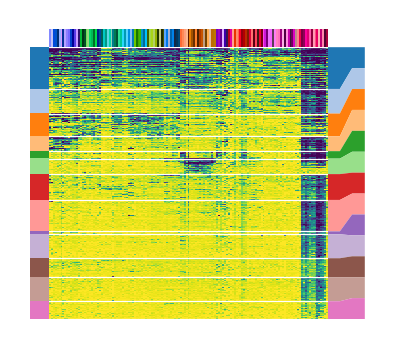

In [24]:
main_size = 15
legend_size = 1
gap_size = 0
linksize = 2
scale = 0.08

gs_rows = main_size + legend_size
gs_cols = main_size + legend_size + gap_size + linksize

fig = plt.figure(figsize=(gs_cols * scale, gs_rows * scale), dpi=300)

gs = fig.add_gridspec(gs_rows, gs_cols, wspace=0, hspace=0)

ax1_heatmap = fig.add_subplot(gs[legend_size:, legend_size:legend_size +
                                 main_size])
ax1_col_legend = fig.add_subplot(gs[:legend_size, legend_size:legend_size +
                                    main_size])
ax1_row_legend = fig.add_subplot(gs[legend_size:, :legend_size])

ax_link = fig.add_subplot(
    gs[legend_size:, legend_size + main_size + gap_size:legend_size +
       main_size + gap_size + linksize])

ax = ax1_heatmap
ax.imshow(related_dmr_rate.values,
          aspect='auto',
          vmin=0,
          vmax=1,
          cmap='viridis')
ax.axis('off')

ax = ax1_row_legend
ax.imshow(np.array(dmr_clusters.map(dmr_palette).tolist())[:, None, :],
          aspect='auto')
ax.axis('off')

ax = ax1_col_legend
ax.imshow(np.array(
    related_dmr_rate.columns.map(sub_type_palette_rgb).tolist())[None, :, :],
          aspect='auto')
ax.axis('off')

ax = ax_link
cluster_counts = dmr_clusters.value_counts().sort_index()
left_y = [0] + (cluster_counts / dmr_clusters.size).cumsum().tolist()
right_y = [0] + list((cluster_counts.index + 1) / cluster_counts.size)

for i in range(cluster_counts.size):
    ax_link.fill_between(x=[0, 0.33, 0.66, 1],
                         y1=[left_y[i], left_y[i], right_y[i], right_y[i]],
                         y2=[left_y[i + 1], left_y[i + 1], right_y[i + 1], right_y[i + 1]],
                         fc=dmr_palette[i])
ax.set(xlim=(0, 1), ylim=(1, 0))
ax.axis('off')

ax = ax1_heatmap
for y in left_y:
    ax.plot((0, 1), (1-y, 1-y), 
            linewidth=0.3, c='white', #linestyle='--', 
            transform=ax.transAxes, clip_on=False)
fig.savefig(gene_dir / 'DMRHeatmap.pdf', bbox_inches='tight')

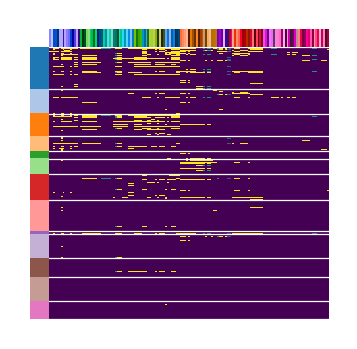

In [25]:
main_size = 15
legend_size = 1
gap_size = 0
linksize = 0
scale = 0.08

gs_rows = main_size + legend_size
gs_cols = main_size + legend_size + gap_size

fig = plt.figure(figsize=(gs_cols * scale, gs_rows * scale), dpi=300)

gs = fig.add_gridspec(gs_rows, gs_cols, wspace=0, hspace=0)

ax1_heatmap = fig.add_subplot(gs[legend_size:, legend_size:legend_size +
                                 main_size])
ax1_col_legend = fig.add_subplot(gs[:legend_size, legend_size:legend_size +
                                    main_size])
ax1_row_legend = fig.add_subplot(gs[legend_size:, :legend_size])

ax = ax1_heatmap
ax.imshow(atac_peak_df.values,
          aspect='auto',
          vmin=0,
          vmax=1,
          cmap='viridis')
ax.axis('off')

ax = ax1_row_legend
ax.imshow(np.array(dmr_clusters.map(dmr_palette).tolist())[:, None, :],
          aspect='auto')
ax.axis('off')

ax = ax1_col_legend
ax.imshow(np.array(
    related_dmr_rate.columns.map(sub_type_palette_rgb).tolist())[None, :, :],
          aspect='auto')
ax.axis('off')

ax = ax1_heatmap
for y in left_y:
    ax.plot((0, 1), (1-y, 1-y), 
            linewidth=0.3, c='white', #linestyle='--', 
            transform=ax.transAxes, clip_on=False)
fig.savefig(gene_dir / 'PeakHeatmap.pdf', bbox_inches='tight')

### Genome locations

In [26]:
cmap = get_cmap('coolwarm')
cnorm = Normalize(vmin=0.3, vmax=0.8)

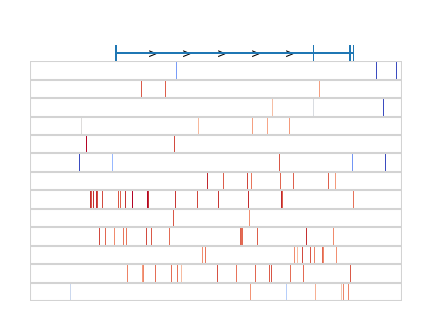

In [27]:
slop_portion = .2

gene_length = gene_end - gene_start
slop = gene_length * slop_portion
n_cluster = gene_cluster['leiden'].unique().size

legend_size = 0
gene_model_size=2
main_height = 15
main_width = 20

gs_rows = gene_model_size + main_height
gs_cols = main_width + legend_size

fig = plt.figure(figsize=(gs_cols * scale, main_size * scale), dpi=300)
gs = fig.add_gridspec(gs_rows, gs_cols, wspace=0, hspace=0)

ax_dmr = fig.add_subplot(gs[gene_model_size:, legend_size:])
ax_gene_model = fig.add_subplot(gs[:gene_model_size, gene_model_size:])
# ax_legend = fig.add_subplot(gs[gene_model_size:, :legend_size])

ax = ax_dmr
for cluster in sorted(dmr_clusters.unique()):
    # print(cluster)
    sub_df = gene_cluster[gene_cluster['leiden'] == cluster]
    ax.axis('off')
    this_dmrs = dmr_bed.loc[sub_df.index]
    for _, row in this_dmrs.iterrows():
        _, start, end = row
        # print(start, end)
        try:
            # corr = gene_cluster.loc[row.name, 'feDMR']
            corr = gene_cluster.loc[row.name, 'Corr']
        except KeyError:
            corr = 0
        y_start = cluster / n_cluster
        y_height = 1 / n_cluster
        p = Rectangle((start, y_start), end - start, y_height, fc=cmap(cnorm(corr)))
        ax.add_patch(p)
ax.set(xlim=(gene_start - slop, gene_end + slop), ylim=(1, 0))
# add line for each cluster separation
for i in range(n_cluster+1):
    y = i / n_cluster
    ax.axhline(y, linewidth=0.5, c='lightgray')
ax.plot((0.001, 0.001), (0, 1), linewidth=0.5, c='lightgray', transform=ax.transAxes)
ax.plot((0.999, 0.999), (0, 1), linewidth=0.5, c='lightgray', transform=ax.transAxes)

# gene body model
ax = ax_gene_model
p = Rectangle((gene_start, 0.45), gene_end - gene_start, 0.1)
ax.add_patch(p)
for _, (exon_start,
        exon_end) in exon_bed.loc[exon_bed['gene_id'] ==
                                  gene_id, ['start', 'end']].iterrows():
    exon_p = Rectangle((exon_start, 0), exon_end - exon_start, 1)
    ax.add_patch(exon_p)
for pos in np.arange(gene_start + (gene_length / 7),
                     gene_end - (gene_length / 7), gene_length / 7):
    ax.text(pos,
            0.5,
            '<' if strand == '-' else '>',
            fontsize=3,
            va='center',
            zorder=-10)
sns.despine(left=True, bottom=True)
xticklabels = ['TSS', 'TES']
if strand == '-':
    xticklabels = xticklabels[::-1]
ax.set(yticks=[],
       ylim=(0, 2),
       xticks=[], #(gene_start, gene_end),
       xticklabels=[],
       xlim=(gene_start - slop, gene_end + slop))



fig.savefig(gene_dir / 'DMRLocation.Corr.pdf', bbox_inches='tight')

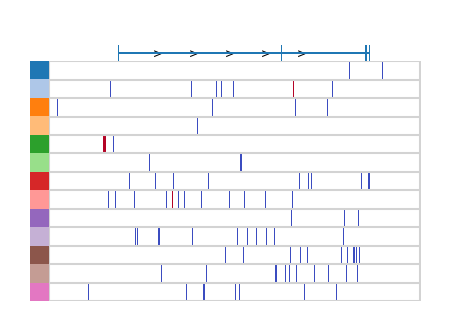

In [28]:
slop_portion = 0.2

gene_length = gene_end - gene_start
slop = gene_length * slop_portion
n_cluster = gene_cluster['leiden'].unique().size

legend_size = 1
gene_model_size=2
main_height = 15
main_width = 20

gs_rows = gene_model_size + main_height
gs_cols = main_width + legend_size

fig = plt.figure(figsize=(gs_cols * scale, main_size * scale), dpi=300)
gs = fig.add_gridspec(gs_rows, gs_cols, wspace=0, hspace=0)

ax_dmr = fig.add_subplot(gs[gene_model_size:, legend_size:])
ax_gene_model = fig.add_subplot(gs[:gene_model_size, gene_model_size:])
ax_legend = fig.add_subplot(gs[gene_model_size:, :legend_size])

ax = ax_dmr
for cluster in sorted(dmr_clusters.unique()):
    # print(cluster)
    sub_df = gene_cluster[gene_cluster['leiden'] == cluster]
    ax.axis('off')
    this_dmrs = dmr_bed.loc[sub_df.index]
    for _, row in this_dmrs.iterrows():
        _, start, end = row
        # print(start, end)
        try:
            corr = gene_cluster.loc[row.name, 'feDMR']
            # corr = gene_cluster.loc[row.name, 'Corr']
        except KeyError:
            corr = 0
        y_start = cluster / n_cluster
        y_height = 1 / n_cluster
        p = Rectangle((start, y_start), end - start, y_height, fc=cmap(cnorm(corr)))
        ax.add_patch(p)
ax.set(xlim=(gene_start - slop, gene_end + slop), ylim=(1, 0))
# add line for each cluster separation
for i in range(n_cluster+1):
    y = i / n_cluster
    ax.axhline(y, linewidth=0.5, c='lightgray')
ax.plot((0.001, 0.001), (0, 1), linewidth=0.5, c='lightgray', transform=ax.transAxes)
ax.plot((0.999, 0.999), (0, 1), linewidth=0.5, c='lightgray', transform=ax.transAxes)

# gene body model
ax = ax_gene_model
p = Rectangle((gene_start, 0.45), gene_end - gene_start, 0.1)
ax.add_patch(p)
for _, (exon_start,
        exon_end) in exon_bed.loc[exon_bed['gene_id'] ==
                                  gene_id, ['start', 'end']].iterrows():
    exon_p = Rectangle((exon_start, 0), exon_end - exon_start, 1)
    ax.add_patch(exon_p)
for pos in np.arange(gene_start + (gene_length / 7),
                     gene_end - (gene_length / 7), gene_length / 7):
    ax.text(pos,
            0.5,
            '<' if strand == '-' else '>',
            fontsize=3,
            va='center',
            zorder=-10)
sns.despine(left=True, bottom=True)
xticklabels = ['TSS', 'TES']
if strand == '-':
    xticklabels = xticklabels[::-1]
ax.set(yticks=[],
       ylim=(0, 2),
       xticks=[], #(gene_start, gene_end),
       xticklabels=[],
       xlim=(gene_start - slop, gene_end + slop))


ax = ax_legend
ax.imshow(np.array([dmr_palette[i] for i in range(n_cluster)])[:, None, :],
          aspect='auto')
ax.axis('off')

fig.savefig(gene_dir / 'DMRLocation.feDMR.pdf', bbox_inches='tight')

## Save DMR info

In [29]:
gene_cluster.to_msgpack(gene_dir / 'DMRInfo.msg', compress='zlib')